## 一、背景

在年末的某個午後，我們收到一項任務：**預估明年度的日活躍設備數（DAU）**。這並非只是數據推估的例行工作，而是關係整體營收目標是否能夠達成的關鍵依據。

對於一款仍在營運中的遊戲產品，**每日活躍設備數（DAU）** 不僅反映了玩家對遊戲的黏著程度，更牽動了使用者數量、新增用戶策略與廣告投放預算的配置。業務部門需要依此規劃成長策略，而我們的任務，就是要用數據，給出有根據的答案。



### 🔍 分析的出發點
該次預估是採用設備數作為標準，定義每日活躍設備數(DAU)拆為舊設備留存數(Daily Old Users,DOU)和新用戶留存數(Retained New Users,RNU)  
$$DAU = DOU + RNU$$
本次預估任務於 **2024/10/01** 開始，基準日設為 **2024/09/30**，並需要以下三個關鍵指標才可計算DOU和RNU：

1. **不同同期群設備的留存率**：用以推估還在遊玩的玩家後續的流失狀況。
2. **各同期群設備群在基準日的留存數**：掌握基準日時，還有多少老用戶活躍中。
3. **預計新增設備數（含每日波動設備數）**：評估未來每天會有多少新設備進入遊戲，補足流失。  
*註：每日波動設備數意旨所有玩家並不會每天上線，但這些今天沒上線的玩家隔天會上線，這個並不是流失，若不考量此數據，會造成大幅低估。

---

### 1. 同期群留存率：找出每一批玩家的黏著力曲線

為了預測未來會留下多少玩家，第一步就是掌握過去各批用戶的「留存曲線」。我們將同時期(可定義為天/月)加入的用戶群體定義為「同期群」，並假設他們在首日（第 0 天）加入後，隨時間流逝，其留存情況會遵循某種遞減規律。

因此，我們使用了常見的**冪次曲線模型**來描述這個現象：

$$
y = ax^b
$$

其中：
- $y$：對應的留存率
- $x$：距離用戶首次登入的天數
- $a, b$：透過最小平方法（Least Squares Method）配適出的參數

由於每日都有新的同期群進入，我們將留存曲線類似的群體歸類，**以10種模型加以建模**，並根據營運活動（如開服首日、大活動）進行調整。為保護數據隱私，所有日期皆已去識別化處理，並假設開服日為 **2023/01/01**。

此外，由於留存率在後期會趨於穩定，我們也加入了「**同比遞減乘數**」的設定（例如乘以 0.99），讓模型更貼近實際用戶行為。例如：

假設 2023/06/18 的同期群在第 400 天（2025/7/23）的預估留存率為  
$$
1.0924 \cdot (400)^{-0.3783} = 11.32\%
$$  
則第 401 天可近似為：  
$$
11.32\% \cdot 0.995 = 11.26\%
$$

$$表1：同期群留存率模型$$
| 編號  | 適用同期群                       | 公式                           | R平方  | 同比率遞減     | 臨界天數 |
|:-----:|:-------------------------------:|:------------------------------:|:-----:|:-----:|:---------:|
| 1     | 2023/01/01                      | $$y=1.2967x ^ {-0.3199}$$       | 0.9077| 0.997 | 400       |
| 2     | 2023/01/02-2023/01/31           | $$y=1.1235x ^ {-0.3459}$$       | 0.9017| 0.997 | 400       |
| 3     | 2023/02 - 2023/06               | $$y=1.0924x ^ {-0.3783}$$       | 0.8853| 0.995 | 400       |
| 4     | 2023/07 - 2023/08               | $$y=1.1192x ^ {-0.4332}$$       | 0.9500| 0.998 | 400       |
| 5     | 2023/09 - 2023/10               | $$y=1.1042x ^ {-0.3966}$$       | 0.9362| 0.994 | 300       |
| 6     | 2023/11 - 2023/12               | $$y=1.0818x ^ {-0.3997}$$       | 0.9394| 0.994 | 400       |
| 7     | 2024/01 - 2024/02               | $$y=1.0360x ^ {-0.4083}$$       | 0.9651| 0.994 | 400       |
| 8     | 2024/03 - 2024/05               | $$y=0.6183x ^ {-0.4339}$$       | 0.9495| 0.996 | 400       |
| 9     | 2024/06                         | $$y=0.5525x ^ {-0.4117}$$       | 0.9780| 0.996 | 400       |
| 10     | 2024/07 - 2024/09               | $$y=0.5113x ^ {-0.4206}$$       | 0.9895| 0.996 | 400       |

<table><tr><td align="center">
  <img src="retention_curve.png" alt="留存率曲線圖" width="600">
</td></tr></table>
$$圖1：各類同期群的留存率曲線$$

---

### 2. 從群體中挖掘：留存設備的真實樣貌

在完成了留存率模型的建構後，我們接下來要回到基準日（2024/09/30），**觀察每一批用戶實際還活躍的設備數**。這一步的核心問題是：**從過去到現在，每個同期群到底還留下了多少玩家？**

我們手上握有完整的玩家角色與設備登入資料。這讓我們能夠根據「首次登入時間」來為玩家設備打上同期群標籤。然而，有些設備其實是無效的，或來自不可信任的來源（我們稱這類為 **UD：Untrusted Devices**），雖然 Adjust (可追蹤FB和Google廣告成效平台) 可判斷該裝置是否為UD，但只有以天為單位的加總值，並不知道其對應的具體玩家id或設備id，如果不排除它們，將會高估留存量，進而導致預測偏差。

### 🧠 解法：讓比例來說話

為了修正這個問題，我們採用一個間接但有效的方法：

1. 先從後台直接取出 **2024/09/30 各同期群的設備留存數**。
2. 將這些數據轉換成「同期群在基準日的占比」。
3. 再將這些占比乘上**Adjust提供的2024/09/30排除UD的活躍設備數**，就可以推估出**先前同期群排除 UD 後的近似設備留存數**。

這樣做的好處是，即使我們無法明確標記每個 UD 設備，也能用「整體比例」去修正偏差。


### 📊 留存設備比例分布表（基準日：2024/09/30）

| 角色首次登入日期 | 同期群占比 | 預估 DAU |
|----------------|-------------|-----------|
| —              | **2024/09/30** | **10,000** |
| 2023/01/01     | 20.00%      | 2,000      |
| 2023/01/02     | 5.71%       | 571       |
| …              | …           | …         |
| 2024/09/29     | 0.33%       | 33        |
| 2024/09/30     | 0.53%       | 53        |


這一節幫助我們**還原基準日時，整個遊戲的活躍用戶結構**，作為預估未來每日 DAU 的基底資料。

---

### 3. 打造成長曲線：預估新增設備數

模型預測的最後一塊拼圖，是**未來會有多少新設備進入遊戲**。

在玩家逐日流失的情況下，如果沒有源源不絕的新用戶加入，整體 DAU 只會一路下滑。因此，我們必須設法估算每日會有多少新設備進入遊戲環境，這將成為支撐未來 DAU 成長的關鍵基礎。


### 🧠 從歷史中找規律：拆解影響因素

我們參考了過往的新增設備數據，將每日新進設備拆解為以下幾個來源：

- **基礎導入（Base）**：日常自然進入遊戲的用戶。
- **假日效果（Holiday）**：週末或國定假日的自然提升。
- **活動影響（Event Buff）**：遊戲內推廣活動帶來的誘因。
- **活動倒數推升（Countdown）**：活動即將結束時的熱度。
- **廣告效益（Ads）**：投放帶來的額外導流。
- **每日波動設備數**：不屬於新進設備的「不常上線」老玩家。

特別要說明的是，**每日波動設備數設定為 80 ，這些用戶並不算真正的「新增玩家」，但會出現在活躍設備中，且每天上線的玩家都為不同批人，放在RNU會高估最後活躍數；若放在DOU則會低估**。本專案最後選擇放在 **RNU**，因此，我們使用近似值 `(MAU - 平均DAU)/30 * 0.2` 作為修正，後續的月份由於活躍人數下降也會導致每日波動數減少，所以可改用80、70、60...的方式遞減，雖然方法較為粗略，但可有效防止模型高估。


### 📅 新增設備數預估表

| 活動名稱           | 日期        | 星期 | 預估新增用戶數 | 基礎值 | 假日增加 | 活動buff | 活動倒數推升 | 每日波動數 | 廣告效益 |
|--------------------|-------------|:----:|:---------------:|:------:|:--------:|:--------:|:------------:|:----------:|:--------:|
|                    | 2024/10/1   | 二   | 160             | 80     |          |          |              | 80         |          |
|                    | 2024/10/2   | 三   | 160             | 80     |          |          |              | 80         |          |
|                    | 2024/10/3   | 四   | 160             | 80     |          |          |              | 80         |          |
| 《大活動》預熱     | 2024/10/4   | 五   | 190             | 80     |          | 30       |              | 80         |          |
| 《大活動》預熱     | 2024/10/5   | 六   | 240             | 80     | 50       | 30       |              | 80         |          |
| 《大活動》         | 2024/10/6   | 日   | 240             | 80     | 50       | 30       |              | 80         |          |
| 《大活動》         | 2024/10/7   | 一   | 190             | 80     |          | 30       |              | 80         |          |
| 《大活動》         | 2024/10/8   | 二   | 190             | 80     |          | 30       |              | 80         |          |
| 《大活動》         | 2024/10/9   | 三   | 190             | 80     |          | 30       |              | 80         |          |
| 《大活動》         | 2024/10/10  | 四   | 190             | 80     |          | 30       |              | 80         |          |
| 《大活動》         | 2024/10/11  | 五   | 220             | 80     |          | 30       | 30           | 80         |          |
| 《大活動》         | 2024/10/12  | 六   | 270             | 80     | 50       | 30       | 30           | 80         |          |
| 《大活動》         | 2024/10/13  | 日   | 240             | 80     | 50       | 30       |              | 80         |          |


這一區塊的預估值將與第10類的留存模型結合，因我們不知新用戶留存的留存率曲線，所以使用日期最接近的同期群留存率曲線 ( $y=0.5113x ^ {-0.4206}$ ) ，推算每日的 **Retained New Users（RNU）**，最終與老玩家的留存數（DOU）合併，構成完整的 DAU 預測：

$$
DAU = DOU + RNU
$$

## **二、公式** 


該次預估是以**設備數**作為分析標準，將每日活躍設備數（DAU）拆解為兩個來源：  
來自歷史同期群的 **舊設備留存數**（Daily Old Users，簡稱 DOU）  
以及基準日之後新增設備的 **新用戶留存數**（Retained New Users，簡稱 RNU）

$$DAU = DOU + RNU$$

---

**1. 定義 BDU（Baseline Day Users）與計算 DOU**

我們以 2024/9/30 作為預測的基準日。此時的 DAU 並非只來自當天的新玩家，而是累積了過去 638 天所有同期群的殘存用戶。因此，基準日的 DAU 可以視為：

2024/09/30 當天加入的設備  
+ 2024/09/29 同期群 × 次日留存率  
+ 2024/09/28 同期群 × 兩日留存率  
+ …  
+ 2023/01/01（開服日）同期群 × 第 638 日留存率  

這樣累積起來的活躍設備數稱為 BDU，可寫為：

$$BDU = bdu_0 +  bdu_1 + ... + bdu_{638}$$  

會需要定義 BDU，是因為我們不是從原始同期群設備數從第 0 天開始估計，而是用基準日 2024/9/30 的 DAU 數值做為基礎，再「**依比例向後預估**」。

例如要估計 2024/10/1 的老用戶留存，  
不是拿 2023/01/01 的同期群設備數 × 1.2967 × $400^{-0.3199} \cdot 0.997^{238}$  
（因為大於臨界天數 400 天，所以超過部分會依照比例遞減）

而是使用 2023/01/01 同期群在 2024/10/01 的留存率<span style="color:#8B0000; font-weight:bold">除以</span>
2023/01/01 同期群在 2024/9/30 的留存率：

$$2000 \times \frac{(1.2967 \cdot 400^{-0.3199} \cdot 0.997^{239})}{(1.2967 \cdot 400^{-0.3199} \cdot 0.997^{238})} = 1982$$

假設該同期群距離基準日是 $m$ 天、距離目標日為 $k$ 天，該同期群總共有 $N_m$ 個設備、$Ret_m$ 為距離基準日 $m$ 天的留存率，令 $y_m$ 為該同期群在目標日的留存數，可寫成：

$$N_m * Ret_m = bdu_m \tag{式1}$$  
$$N_m * Ret_k = y_m \tag{式2}$$  

(式2) 除以 (式1) 可得：

$$y_m = bdu_m * Ret_k/Ret_m \tag{式3}$$

我們不直接使用 (式1)，因為已有距離目標日相近的基準日數據，所以將此做為基準往後預估。

DOU 為所有老用戶同期群的留存總和，可得：

$$DOU = y_0 + y_1 + ... $$

其中 $y_0$ 為基準日(2024/09/30)當日的新進用戶數在目標日的留存，$y_1$ 為基準日前一日(2024/09/29)的新進用戶數在目標日的留存，以此類推。所以 DOU 的組成主要是靠式 (3) 去計算後加總而來。  
如果將基準日訂為 2024/9/30，開服日為 2023/01/01，則每次計算目標日 DOU 的 y 項固定會有 **639 項**。

**2. 計算 RNU**

根據 (式1) 的邏輯，我們也可以同理推算 RNU（Retained New Users）。  
RNU 的預測主要取決於兩個關鍵變數：  
👉 每日的「新增設備數」  
👉 對應天數的「留存率」

其中，新增設備數可直接取自**表 3**的「預計新增用戶數」欄位；  
而留存率模型部分，則以**表 1 中編號 10 的留存曲線**作為新設備的通用預估依據，因其為近期活動的最新同期群模型，最能代表未來新增設備的行為趨勢。

舉例來說，若要計算 **2024/10/3 的 RNU**，就需要將：

- 該日（2024/10/3）的新增設備數  
- 加上前一天（2024/10/2）新增設備的次日留存  
- 加上兩天前（2024/10/1）新增設備的兩日留存  
 

這樣組成的總和，就是目標日當天所有新用戶設備的留存量。

其通式可表示為：

$$
RNU = N_0 + N_1 \cdot Ret_1 + N_2 \cdot Ret_2 + ... + N_{k-m} \cdot Ret_{t}
$$

其中，$N_x$ 代表目標日前第 $x$ 天的新增設備數，  
$Ret_x$ 則代表該批設備在第 $x$ 天的留存率，  
$t$為目標日距離基準日 +1 的天數。

---

### 三、實例

假設開服日為 2023/01/01，預測基準日為 2024/9/30，而我們要估計的目標日是 2024/10/3。  
此區間內，根據預估每日會新增 160 台設備（包含每日波動數），我們便可以使用表 1 中 `編號10` 的留存率模型來推估目標日的 RNU。

RNU 的計算方式如下：

$$
160 \cdot 0.5113 \cdot 2^{-0.4206} + 160 \cdot 0.5113 \cdot 1^{-0.4206} + 160 = 302.93
$$


DOU 的計算則需根據各同期群的模型（見表 1）逐一使用對應的留存率公式計算。  
以 2023/01/01 為例，距離目標日為 641 天，屬於 `編號1` 的留存模型，則使用 1.2967 的曲線係數與 0.997 的比率遞減進行計算。  
依此類推，我們將部分代表性同期群的推估結果列示如下（詳見表 4）：


#### 表 4：同期群於 2024/10/3 的留存估計

| 同期群日     | 基準日       | 目標日       | 距離目標日天數 | 距離基準日天數 | 該同期群在基準日留存數 | 留存率公式                         | 計算方式                                                              | 留存數     |
|--------------|--------------|--------------|----------------|----------------|-------------------------|-------------------------------------|------------------------------------------------------------------------|------------|
| 2023/01/01    | 2024/9/30    | 2024/10/3    | 641            | 638            | 2000                    | $$y=1.2967x ^ {-0.3199}$$           | $$2000 * \frac{1.2967\cdot 400 ^ {-0.3199} \cdot 0.997^{241}}{1.2967\cdot 400 ^ {-0.3199} \cdot 0.997^{238}}$$         | 1982    |
| 2023/01/02    | 2024/9/30    | 2024/10/3    | 640            | 637            | 571                     | $$y=1.0924x ^ {-0.3783}$$           | $$571 * \frac{1.0924\cdot 400 ^ {-0.3783} \cdot 0.995^{240}}{1.0924\cdot 400 ^ {-0.3783} \cdot 0.995^{237}}$$         | 562    |
| …            | …            | …            | …              | …              | …                         | …                                   | …                                                                      | …          |
| 2023/7/1     | 2024/9/30    | 2024/10/3    | 460            | 457            | 3                     | $$y=1.1192x ^ {-0.4332}$$           | $$3 * \frac{1.1192\cdot 400 ^ {-0.4332} \cdot 0.998^{60}}{1.1192\cdot 400 ^ {-0.4332} \cdot 0.998^{57}}$$         |   3   |
| …            | …            | …            | …              | …              | …                         | …                                   | …                                                                      | …          |
| 2024/9/29    | 2024/9/30    | 2024/10/3    | 4              | 1              | 33                      | $$y=0.5113x ^ {-0.4206}$$           | $$33 \cdot \frac{0.5113\cdot 4 ^ {-0.4206}}{0.5113\cdot 1 ^ {-0.4206}}$$              | 18.42      |
| 2024/9/30    | 2024/9/30    | 2024/10/3    | 3              | 0              | 53                      | $$y=0.5113x ^ {-0.4206}$$           | $$53 \cdot 0.5113 \cdot 3 ^ {-0.4206}$$                                           | 17.07      |
| **總和**     |              |              |                |                |                           |                                     |                                                                        | **a**|

---

最後，我們將 RNU 和 DOU 相加，即可得出 2024/10/3 的預估日活躍設備數（DAU）：

$$
DAU = DOU + RNU =  +  =  \approx 
$$


In [2]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

In [3]:
plt.rc('font', family='Microsoft JhengHei')

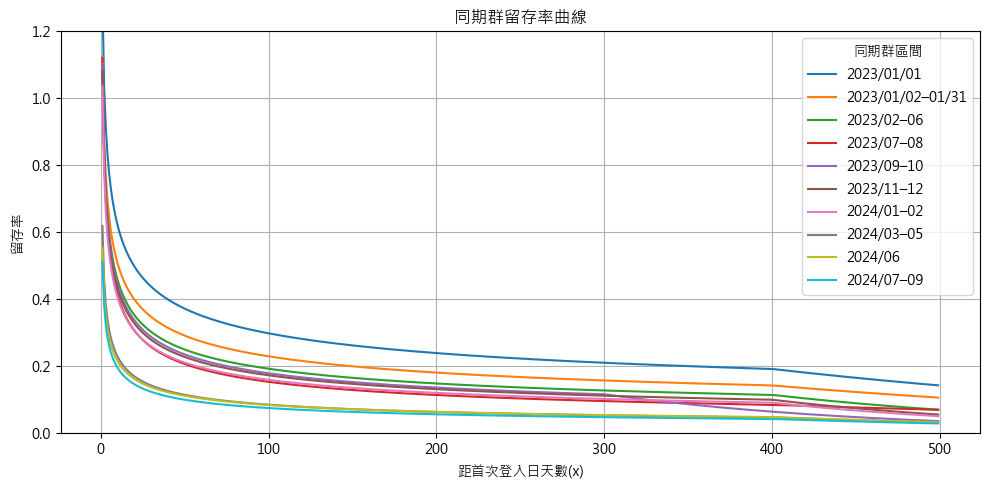

In [12]:
# 定義每個同期群的模型參數
models = [
    {"label": "2023/01/01", "a": 1.2967, "b": -0.3199, "days": 400, "rate": 0.997},
    {"label": "2023/01/02–01/31", "a": 1.1235, "b": -0.3459, "days": 400, "rate": 0.997},
    {"label": "2023/02–06", "a": 1.0924, "b": -0.3783, "days": 400, "rate": 0.995},
    {"label": "2023/07–08", "a": 1.1192, "b": -0.4332, "days": 400, "rate": 0.998},
    {"label": "2023/09–10", "a": 1.1042, "b": -0.3966, "days": 300, "rate": 0.994},
    {"label": "2023/11–12", "a": 1.0818, "b": -0.3997, "days": 400, "rate": 0.994},
    {"label": "2024/01–02", "a": 1.0360, "b": -0.4083, "days": 400, "rate": 0.994},
    {"label": "2024/03–05", "a": 0.6183, "b": -0.4339, "days": 400, "rate": 0.996},
    {"label": "2024/06", "a": 0.5525, "b": -0.4117, "days": 400, "rate": 0.996},
    {"label": "2024/07–09", "a": 0.5113, "b": -0.4206, "days": 400, "rate": 0.996},
]

# 畫圖
plt.figure(figsize=(10, 5))
for m in models:
    x = np.arange(1, 500)
    y = []
    for i in x:
        if i <= m["days"]:
            y.append(m["a"] * i ** m["b"])
        else:
            # 從臨界點後乘上同比率遞減
            base_value = m["a"] * m["days"] ** m["b"]
            decay_factor = m["rate"] ** (i - m["days"])
            y.append(base_value * decay_factor)
    plt.plot(x, y, label=m["label"])

plt.title("同期群留存率曲線")
plt.xlabel("距首次登入日天數(x)")
plt.ylabel("留存率")
plt.ylim(0, 1.2)
plt.grid(True)
plt.legend(title="同期群區間")
plt.tight_layout()
# plt.savefig("retention_curve.png") 
plt.show()



In [62]:
df = pd.read_excel("C:\\Users\\sammi.chiu\\Desktop\\【專案】預估日活用戶數：支撐預算規劃與新用戶成長策略\\202410-202512預計新增用戶數.xlsx",sheet_name="預計新增")
retained_DOU_240930 = pd.read_excel("C:\\Users\\sammi.chiu\\Desktop\\【專案】預估日活用戶數：支撐預算規劃與新用戶成長策略\\20240930同期群留存.xlsx",sheet_name=0)

In [63]:
# 起始和结束日期
start_date = datetime(2024, 10, 1)
end_date = datetime(2025, 12, 31)

# 生成日期列表
date_list = []
current_date = start_date

while current_date <= end_date:
    date_list.append(current_date)  # 格式化为字符串
    current_date += timedelta(days=1)

In [64]:
retained_DOU_240930['日(角色首次登入日期)'] = pd.to_datetime(retained_DOU_240930['日(角色首次登入日期)'], unit='D', origin='1899-12-30')

In [65]:
group = [
    "2023/01/01",
    "2023/01/02 - 2023/01/31",
    "2023/02 - 2023/06",
    "2023/07 - 2023/08",
    "2023/09 - 2023/10",
    "2023/11 - 2023/12",
    "2024/01 - 2024/02",
    "2024/03 - 2024/05",
    "2024/06",
    "2024/07 - 2024/09"
]
a = [1.2967, 1.1235, 1.0924, 1.1192, 1.1042, 1.0818, 1.0360, 0.6183, 0.5525, 0.5113]
b = [-0.3199, -0.3459, -0.3783, -0.4332, -0.3966, -0.3997, -0.4083, -0.4339, -0.4117, -0.4206]
rate = [0.997, 0.997, 0.995, 0.998, 0.994, 0.994, 0.994, 0.996, 0.996, 0.996]
limit = [400, 400, 400, 400, 300, 400, 400, 400, 400, 400]
fit_results_df = pd.DataFrame({'group':group,'a': a, 'b':b, 'rate':rate, 'limit':limit},)

In [66]:
 retained_DOU_240930

,日(角色首次登入日期),2024/9/30高質量角色留存,AD設備-UD留存數(10000)
0,2023-01-01,0.2000,2000.0
1,2023-01-02,0.0571,571.0
2,2023-01-03,0.0308,308.0
3,2023-01-04,0.0208,208.0
4,2023-01-05,0.0180,180.0
...,...,...,...
634,2024-09-26,0.0010,10.0
635,2024-09-27,0.0021,21.0
636,2024-09-28,0.0029,29.0
637,2024-09-29,0.0033,33.0


In [69]:
# 基準日
type_mapping = {
    datetime(2023, 1, 1): 0,
    (2023, 1): 1,
    (2023, 2): 2,
    (2023, 3): 2,
    (2023, 4): 2,
    (2023, 5): 2,
    (2023, 6): 2,
    (2023, 7): 3,
    (2023, 8): 3,
    (2023, 9): 4,
    (2023, 10): 4,
    (2023, 11): 5,
    (2023, 12): 5,
    (2024, 1): 6,
    (2024, 2): 6,
    (2024, 3): 7,
    (2024, 4): 7,
    (2024, 5): 7,
    (2024, 6): 8,
    (2024, 7): 9,
    (2024, 8): 9,
    (2024, 9): 9,
}
past_DOU = []
baseline_date = datetime(2024, 9, 30)
for target_date in date_list[:]:
    retained = 0
    for cal_date in retained_DOU_240930.iloc[:, 0]:
        past_days = (target_date - cal_date).days
        devisor_days = (baseline_date - cal_date).days
        # 獲取類型
        type = type_mapping.get((cal_date.year, cal_date.month)) if (cal_date.year, cal_date.month) in type_mapping else None
        if cal_date == datetime(2023,1,1):
            type = 0
        if type is not None:
            a = fit_results_df.iloc[type, 1]
            b = fit_results_df.iloc[type, 2]
            rate = fit_results_df.iloc[type, 3]
            limit = fit_results_df.iloc[type, 4]
            if devisor_days == 0:
                final_rate = a * (past_days ** b)        
            elif past_days <= limit:
                final_rate = (a * (past_days ** b)) / (a * ((devisor_days) ** b))
            elif past_days > limit:
                final_rate = rate**(past_days-devisor_days)
            
            # 獲取 dou 值
            dou = retained_DOU_240930['AD設備-UD留存數(10000)'][retained_DOU_240930['日(角色首次登入日期)'] == cal_date].values[0]
            
            # 更新 retained
            retained += dou * final_rate
    past_DOU.append(retained)

In [71]:
print(past_DOU[:10],"\n",past_DOU[-10:])

[9917.143112923199, 9861.903299201811, 9814.144050575502, 9769.926289167679, 9727.911729265856, 9687.483825232444, 9648.251967357563, 9609.980360674517, 9572.50813430946, 9535.719737761097] 
 [1989.246608081704, 1982.520894650895, 1975.8194666700178, 1969.1422298863781, 1962.4890904414283, 1955.8599548689679, 1949.2547300934318, 1942.6733234280616, 1936.1156425731913, 1929.581595614547]


In [76]:
# 設定每天新增用戶數列表
daily_new_users_list = df['預計新增用戶數'][:]  
retention = []  # 存放每天的留存數
days = len(daily_new_users_list)  # 確認總天數
    
for day in range(1, days+1):
    # 當天的留存數
    daily_retention = 0
    for past_day in range(0, day):
        # 計算每天新增的用戶留存率
        new_users = daily_new_users_list[past_day]
        if (day - past_day-1) == 0:
            rate = 1 
        elif (day - past_day -1) > 400:
            rate = 0.5113 * (400)**(-0.4206)* (0.996**(day - past_day - 1 -400)) 
        else:
            rate = 0.5113 * (day - past_day - 1)**(-0.4206) 
        daily_retention += new_users * rate  
    retention.append(daily_retention)
retention[-10:]

[4319.155288641168,
 4305.6468762715685,
 4295.684763082429,
 4287.367597983466,
 4280.079718642399,
 4303.52724757571,
 4312.878532621515,
 4338.7983942023575,
 4353.5171616103025,
 4364.866897142939]

In [81]:
DAU = []
for i in range(len(retention)):
    DAU.append(retention[i]+past_DOU[i])
print(DAU[-10:])

[6308.401896722872, 6288.167770922463, 6271.504229752447, 6256.509827869844, 6242.568809083827, 6259.387202444678, 6262.133262714947, 6281.471717630419, 6289.632804183494, 6294.448492757486]


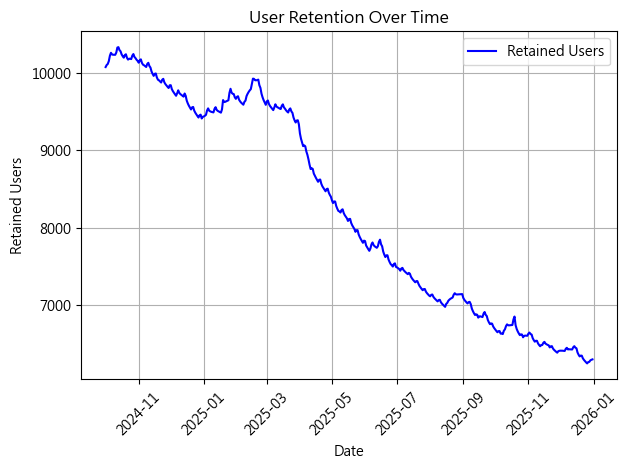

In [77]:
# 使用 matplotlib 繪製折線圖
# plt.figure(figsize=(10, 6))
plt.plot(date_list, DAU,  linestyle='-', color='b', label='Retained Users')

# 添加圖表標題和標籤
plt.title('User Retention Over Time')
plt.xlabel('Date')
plt.ylabel('Retained Users')
plt.grid(True)
plt.xticks(rotation=45)  # 將日期標籤旋轉 45 度

# 添加圖例
plt.legend()

# 顯示圖表
plt.tight_layout()  # 自動調整圖表佈局
plt.show()

In [78]:
result = pd.DataFrame({
    'Date': date_list,
    'DAU': DAU
})

In [79]:
result

,Date,DAU
0,2024-10-01,10077.143113
1,2024-10-02,10103.711299
2,2024-10-03,10117.071940
3,2024-10-04,10154.391112
4,2024-10-05,10223.379068
...,...,...
452,2025-12-27,6259.387202
453,2025-12-28,6262.133263
454,2025-12-29,6281.471718
455,2025-12-30,6289.632804
